In [1]:
# UNet Training Pipeline for Histopathology Segmentation
# ========================================================

import sys
import torch
import torch.nn as nn
import numpy as np

# Import UNet from CNNs folder
from CNNs.UNet import UNet

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA device:", torch.cuda.get_device_name(0))

PyTorch version: 2.5.1+cu118
CUDA available: True
CUDA device: NVIDIA GeForce RTX 4050 Laptop GPU


In [2]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize UNet model for multi-class segmentation (5 tissue types)
print("\nInitializing UNet model...")
model = UNet(
    in_channels=3,       # RGB input
    out_channels=5,      # 5 tissue classes
    base_filters=64,     # Base number of filters
    depth=4,             # 4 downsampling/upsampling levels
    bilinear=False       # Use transposed convolutions
)

print("✓ UNet model initialized successfully!")

Using device: cuda

Initializing UNet model...
✓ UNet model initialized successfully!


In [3]:
# Get model information
model_info = model.get_model_info()

print("="*80)
print("UNET MODEL INFORMATION")
print("="*80)

for key, value in model_info.items():
    if 'parameters' in key:
        print(f"{key}: {value:,}")
    else:
        print(f"{key}: {value}")

# Test forward pass
print("\n" + "="*80)
print("TEST FORWARD PASS")
print("="*80)
test_input = torch.randn(2, 3, 224, 224)
with torch.no_grad():
    test_output = model(test_input)
print(f"Input shape: {test_input.shape}")
print(f"Output shape: {test_output.shape}")
print(f"Expected: [2, 5, 224, 224]")
print("✓ Forward pass successful!" if test_output.shape == (2, 5, 224, 224) else "✗ Shape mismatch!")

UNET MODEL INFORMATION
architecture: UNet
input_channels: 3
output_channels: 5
base_filters: 64
depth: 4
bilinear_upsampling: False
total_parameters: 31,037,893
trainable_parameters: 31,037,893

TEST FORWARD PASS
Input shape: torch.Size([2, 3, 224, 224])
Output shape: torch.Size([2, 5, 224, 224])
Expected: [2, 5, 224, 224]
✓ Forward pass successful!


In [4]:
# Import additional libraries for training
import pandas as pd
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt
import os
from datetime import datetime

print("Training libraries imported!")

c:\Users\nikhi\AppData\Local\Programs\Python\Python312\Lib\site-packages\albumentations\__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.24). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Training libraries imported!


In [5]:
# Load dataset and preprocess
df = pd.read_csv('Dataset/Images_With_Unique_Labels_Refer_Segmentation_Task_Small.csv')
print(f"Dataset loaded: {len(df)} samples")
print(f"\nColumns: {df.columns.tolist()}")

# Parse classes into binary columns
class_names = ['Neoplastic', 'Inflammatory', 'Connective_Soft_tissue', 'Epithelial', 'Dead']

for class_name in class_names:
    df[class_name] = df['classes'].apply(lambda x: 1 if class_name in x else 0)

# Add mask paths - masks follow pattern: {base_name}_channel_{idx}_{class_name}.png
df['base_name'] = df['image_path'].str.replace('_img.png', '')

print(f"\nClass distribution:")
for col in class_names:
    count = df[col].sum()
    print(f"  {col}: {count} ({count/len(df)*100:.1f}%)")

Dataset loaded: 100 samples

Columns: ['image_id', 'image_path', 'classes', 'organ', 'classes_clean', 'instruction']

Class distribution:
  Neoplastic: 100 (100.0%)
  Inflammatory: 87 (87.0%)
  Connective_Soft_tissue: 100 (100.0%)
  Epithelial: 8 (8.0%)
  Dead: 3 (3.0%)


In [6]:
# Custom Dataset Class (same as temp.ipynb)
class HistopathologyDataset(Dataset):
    def __init__(self, dataframe, img_dir='Dataset/multi_images', mask_dir='Dataset/multi_masks', 
                 transform=None, img_size=224):
        self.df = dataframe.reset_index(drop=True)
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.img_size = img_size
        self.class_names = ['Neoplastic', 'Inflammatory', 'Connective_Soft_tissue', 'Epithelial', 'Dead']
        self.channel_mapping = {
            'Neoplastic': 0,
            'Inflammatory': 1,
            'Connective_Soft_tissue': 2,
            'Dead': 3,
            'Epithelial': 4
        }
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Load image
        img_path = os.path.join(self.img_dir, row['image_path'])
        image = cv2.imread(img_path)
        if image is None:
            raise FileNotFoundError(f"Image not found: {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Load masks for each class (following channel naming convention)
        base_name = row['base_name']
        masks = []
        
        for class_name in self.class_names:
            channel_idx = self.channel_mapping[class_name]
            mask_filename = f"{base_name}_channel_{channel_idx}_{class_name}.png"
            mask_path = os.path.join(self.mask_dir, mask_filename)
            
            if os.path.exists(mask_path):
                mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                mask = (mask > 127).astype(np.uint8)  # Binarize
            else:
                # If mask doesn't exist, create empty mask
                mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
            
            masks.append(mask)
        
        # Stack masks: [H, W, num_classes]
        masks = np.stack(masks, axis=-1)
        
        # Apply augmentations
        if self.transform:
            augmented = self.transform(image=image, mask=masks)
            image = augmented['image']
            masks = augmented['mask']
        
        # Convert to tensors
        if isinstance(image, np.ndarray):
            image = torch.from_numpy(image).permute(2, 0, 1).float()
        elif isinstance(image, torch.Tensor) and image.ndim == 3 and image.shape[-1] == 3:
            image = image.permute(2, 0, 1).float()
        
        if isinstance(masks, np.ndarray):
            masks = torch.from_numpy(masks).permute(2, 0, 1).float()
        elif isinstance(masks, torch.Tensor) and masks.ndim == 3 and masks.shape[-1] == len(self.class_names):
            masks = masks.permute(2, 0, 1).float()
        
        # Get class presence (binary vector)
        class_presence = torch.tensor([row[cls] for cls in self.class_names], dtype=torch.float32)
        
        return {
            'image': image,
            'masks': masks,
            'class_presence': class_presence,
            'image_name': row['image_path']
        }

print("Dataset class defined!")

Dataset class defined!


In [7]:
# Define augmentations
train_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Custom collate function
def custom_collate(batch):
    images = []
    masks = []
    class_presence = []
    image_names = []
    
    for item in batch:
        images.append(item['image'])
        mask = item['masks']
        if mask.shape[0] != 5:
            mask = mask.permute(2, 0, 1)
        masks.append(mask)
        class_presence.append(item['class_presence'])
        image_names.append(item['image_name'])
    
    return {
        'image': torch.stack(images),
        'masks': torch.stack(masks),
        'class_presence': torch.stack(class_presence),
        'image_name': image_names
    }

# Train-val split
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df[class_names].sum(axis=1))
print(f"Train samples: {len(train_df)}")
print(f"Val samples: {len(val_df)}")

# Create datasets
train_dataset = HistopathologyDataset(train_df, transform=train_transform)
val_dataset = HistopathologyDataset(val_df, transform=val_transform)

# Create dataloaders
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, 
                          pin_memory=True, collate_fn=custom_collate)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, 
                        pin_memory=True, collate_fn=custom_collate)

print(f"\nDataLoaders created!")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

Train samples: 80
Val samples: 20

DataLoaders created!
Train batches: 20
Val batches: 5


In [8]:
# Metrics: Dice Score and IoU
def dice_score(pred, target, smooth=1e-6, per_class=False):
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
    dice = (2. * intersection + smooth) / (union + smooth)
    
    if per_class:
        return dice.mean(dim=0)
    else:
        return dice.mean()

def iou_score(pred, target, smooth=1e-6, per_class=False):
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3)) - intersection
    iou = (intersection + smooth) / (union + smooth)
    
    if per_class:
        return iou.mean(dim=0)
    else:
        return iou.mean()

# Combined Loss: BCE + Dice Loss
class CombinedLoss(nn.Module):
    def __init__(self, bce_weight=0.5, dice_weight=0.5):
        super().__init__()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
        self.bce = nn.BCEWithLogitsLoss()
        
    def dice_loss(self, pred, target, smooth=1e-6):
        pred = torch.sigmoid(pred)
        intersection = (pred * target).sum(dim=(2, 3))
        union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
        dice = (2. * intersection + smooth) / (union + smooth)
        return 1 - dice.mean()
    
    def forward(self, pred, target):
        bce = self.bce(pred, target)
        dice = self.dice_loss(pred, target)
        return self.bce_weight * bce + self.dice_weight * dice

print("Metrics and loss functions defined!")

Metrics and loss functions defined!


In [9]:
# Training Configuration
config = {
    'num_epochs': 10,
    'learning_rate': 1e-4,
    'weight_decay': 1e-5,
    'device': device,
    'save_dir': 'checkpoints',
    'best_model_path': 'checkpoints/best_unet_model.pth',
}

os.makedirs(config['save_dir'], exist_ok=True)

model = model.to(config['device'])
criterion = CombinedLoss(bce_weight=0.5, dice_weight=0.5)
optimizer = AdamW(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
scheduler = CosineAnnealingLR(optimizer, T_max=config['num_epochs'], eta_min=1e-6)

print("Training configuration set!")
print(f"Device: {config['device']}")
print(f"Epochs: {config['num_epochs']}")
print(f"Learning rate: {config['learning_rate']}")

Training configuration set!
Device: cuda
Epochs: 10
Learning rate: 0.0001


In [10]:
# Training and Validation Functions for UNet
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    
    class_names = ['Neoplastic', 'Inflammatory', 'Connective', 'Epithelial', 'Dead']
    num_classes = len(class_names)
    
    running_loss = 0.0
    running_dice = torch.zeros(num_classes)
    running_iou = torch.zeros(num_classes)
    
    pbar = tqdm(loader, desc='Training', leave=False)
    for batch in pbar:
        images = batch['image'].to(device)
        masks = batch['masks'].to(device)
        
        # Forward pass (UNet only takes images, no text)
        optimizer.zero_grad()
        pred_masks = model(images)  # Direct output [B, 5, H, W]
        
        # Calculate loss
        loss = criterion(pred_masks, masks)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Calculate metrics
        with torch.no_grad():
            pred_sigmoid = torch.sigmoid(pred_masks)
            dice_per_class = dice_score(pred_sigmoid, masks, per_class=True)
            iou_per_class = iou_score(pred_sigmoid, masks, per_class=True)
        
        running_loss += loss.item()
        running_dice += dice_per_class.cpu()
        running_iou += iou_per_class.cpu()
        
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'dice': f'{dice_per_class.mean().item():.4f}',
            'iou': f'{iou_per_class.mean().item():.4f}'
        })
    
    epoch_loss = running_loss / len(loader)
    epoch_dice = running_dice / len(loader)
    epoch_iou = running_iou / len(loader)
    
    return epoch_loss, epoch_dice, epoch_iou

def validate_epoch(model, loader, criterion, device):
    model.eval()
    
    class_names = ['Neoplastic', 'Inflammatory', 'Connective', 'Epithelial', 'Dead']
    num_classes = len(class_names)
    
    running_loss = 0.0
    running_dice = torch.zeros(num_classes)
    running_iou = torch.zeros(num_classes)
    
    pbar = tqdm(loader, desc='Validation', leave=False)
    with torch.no_grad():
        for batch in pbar:
            images = batch['image'].to(device)
            masks = batch['masks'].to(device)
            
            # Forward pass (UNet only takes images)
            pred_masks = model(images)  # Direct output [B, 5, H, W]
            
            # Calculate loss
            loss = criterion(pred_masks, masks)
            
            # Calculate metrics
            pred_sigmoid = torch.sigmoid(pred_masks)
            dice_per_class = dice_score(pred_sigmoid, masks, per_class=True)
            iou_per_class = iou_score(pred_sigmoid, masks, per_class=True)
            
            running_loss += loss.item()
            running_dice += dice_per_class.cpu()
            running_iou += iou_per_class.cpu()
            
            pbar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'dice': f'{dice_per_class.mean().item():.4f}',
                'iou': f'{iou_per_class.mean().item():.4f}'
            })
    
    epoch_loss = running_loss / len(loader)
    epoch_dice = running_dice / len(loader)
    epoch_iou = running_iou / len(loader)
    
    return epoch_loss, epoch_dice, epoch_iou

print("Training and validation functions defined!")

Training and validation functions defined!


In [11]:
# Main Training Loop
class_names = ['Neoplastic', 'Inflammatory', 'Connective', 'Epithelial', 'Dead']

history = {
    'train_loss': [], 'train_dice': [], 'train_iou': [],
    'val_loss': [], 'val_dice': [], 'val_iou': []
}

best_val_dice = 0.0
start_time = datetime.now()

print("="*80)
print("STARTING UNET TRAINING")
print("="*80)
print(f"Start time: {start_time.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Batch size: {batch_size}")
print("="*80)

for epoch in range(config['num_epochs']):
    print(f"\nEpoch [{epoch+1}/{config['num_epochs']}]")
    print("-" * 80)
    
    # Train
    train_loss, train_dice, train_iou = train_epoch(
        model, train_loader, criterion, optimizer, config['device']
    )
    
    # Validate
    val_loss, val_dice, val_iou = validate_epoch(
        model, val_loader, criterion, config['device']
    )
    
    # Update learning rate
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_dice'].append(train_dice.mean().item())
    history['train_iou'].append(train_iou.mean().item())
    history['val_loss'].append(val_loss)
    history['val_dice'].append(val_dice.mean().item())
    history['val_iou'].append(val_iou.mean().item())
    
    # Print epoch summary
    print(f"\n{'Metric':<20} {'Train':>12} {'Val':>12}")
    print("-" * 47)
    print(f"{'Loss':<20} {train_loss:>12.4f} {val_loss:>12.4f}")
    print(f"{'Dice Score (Mean)':<20} {train_dice.mean():>12.4f} {val_dice.mean():>12.4f}")
    print(f"{'IoU Score (Mean)':<20} {train_iou.mean():>12.4f} {val_iou.mean():>12.4f}")
    
    # Print per-class metrics
    print(f"\n{'Class':<20} {'Train Dice':>12} {'Val Dice':>12} {'Train IoU':>12} {'Val IoU':>12}")
    print("-" * 77)
    for i, class_name in enumerate(class_names):
        print(f"{class_name:<20} {train_dice[i]:>12.4f} {val_dice[i]:>12.4f} {train_iou[i]:>12.4f} {val_iou[i]:>12.4f}")
    
    print(f"\n{'Learning Rate':<20} {current_lr:>12.6f}")
    
    # Save best model
    val_dice_mean = val_dice.mean().item()
    if val_dice_mean > best_val_dice:
        best_val_dice = val_dice_mean
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_dice': val_dice_mean,
            'val_dice_per_class': val_dice.tolist(),
            'val_iou': val_iou.mean().item(),
            'val_loss': val_loss,
        }, config['best_model_path'])
        print(f"✓ Best model saved! (Mean Dice: {val_dice_mean:.4f})")

end_time = datetime.now()
training_time = end_time - start_time

print("\n" + "="*80)
print("TRAINING COMPLETED!")
print("="*80)
print(f"End time: {end_time.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Training duration: {training_time}")
print(f"Best validation Dice score: {best_val_dice:.4f}")
print(f"Best model saved at: {config['best_model_path']}")
print("="*80)

STARTING UNET TRAINING
Start time: 2025-12-20 14:51:00
Training samples: 80
Validation samples: 20
Batch size: 4

Epoch [1/10]
--------------------------------------------------------------------------------


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]


Metric                      Train          Val
-----------------------------------------------
Loss                       0.8528       0.8479
Dice Score (Mean)          0.0553       0.0607
IoU Score (Mean)           0.0335       0.0372

Class                  Train Dice     Val Dice    Train IoU      Val IoU
-----------------------------------------------------------------------------
Neoplastic                 0.1671       0.2316       0.1070       0.1470
Inflammatory               0.0363       0.0210       0.0203       0.0116
Connective                 0.0708       0.0414       0.0393       0.0223
Epithelial                 0.0023       0.0095       0.0012       0.0052
Dead                       0.0000       0.0000       0.0000       0.0000

Learning Rate            0.000098
✓ Best model saved! (Mean Dice: 0.0607)

Epoch [2/10]
--------------------------------------------------------------------------------


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]


Metric                      Train          Val
-----------------------------------------------
Loss                       0.7963       0.8431
Dice Score (Mean)          0.0820       0.0668
IoU Score (Mean)           0.0524       0.0418

Class                  Train Dice     Val Dice    Train IoU      Val IoU
-----------------------------------------------------------------------------
Neoplastic                 0.2325       0.2240       0.1600       0.1456
Inflammatory               0.0730       0.0414       0.0426       0.0246
Connective                 0.1039       0.0683       0.0592       0.0386
Epithelial                 0.0006       0.0003       0.0003       0.0001
Dead                       0.0000       0.0000       0.0000       0.0000

Learning Rate            0.000091
✓ Best model saved! (Mean Dice: 0.0668)

Epoch [3/10]
--------------------------------------------------------------------------------


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]


Metric                      Train          Val
-----------------------------------------------
Loss                       0.7751       0.9049
Dice Score (Mean)          0.0865       0.0766
IoU Score (Mean)           0.0553       0.0491

Class                  Train Dice     Val Dice    Train IoU      Val IoU
-----------------------------------------------------------------------------
Neoplastic                 0.2318       0.2684       0.1579       0.1794
Inflammatory               0.0557       0.0263       0.0312       0.0141
Connective                 0.1397       0.0884       0.0841       0.0521
Epithelial                 0.0055       0.0001       0.0035       0.0000
Dead                       0.0000       0.0000       0.0000       0.0000

Learning Rate            0.000080
✓ Best model saved! (Mean Dice: 0.0766)

Epoch [4/10]
--------------------------------------------------------------------------------


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]


Metric                      Train          Val
-----------------------------------------------
Loss                       0.7620       0.9191
Dice Score (Mean)          0.0889       0.0820
IoU Score (Mean)           0.0579       0.0529

Class                  Train Dice     Val Dice    Train IoU      Val IoU
-----------------------------------------------------------------------------
Neoplastic                 0.2396       0.2670       0.1680       0.1782
Inflammatory               0.0558       0.0347       0.0313       0.0196
Connective                 0.1479       0.1081       0.0899       0.0668
Epithelial                 0.0012       0.0001       0.0006       0.0000
Dead                       0.0000       0.0000       0.0000       0.0000

Learning Rate            0.000066
✓ Best model saved! (Mean Dice: 0.0820)

Epoch [5/10]
--------------------------------------------------------------------------------


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]


Metric                      Train          Val
-----------------------------------------------
Loss                       0.7526       0.7731
Dice Score (Mean)          0.1511       0.1450
IoU Score (Mean)           0.1195       0.1153

Class                  Train Dice     Val Dice    Train IoU      Val IoU
-----------------------------------------------------------------------------
Neoplastic                 0.2609       0.2728       0.1879       0.1832
Inflammatory               0.0489       0.0371       0.0275       0.0219
Connective                 0.1709       0.1153       0.1073       0.0712
Epithelial                 0.2750       0.3000       0.2750       0.3000
Dead                       0.0000       0.0000       0.0000       0.0000

Learning Rate            0.000051
✓ Best model saved! (Mean Dice: 0.1450)

Epoch [6/10]
--------------------------------------------------------------------------------


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]


Metric                      Train          Val
-----------------------------------------------
Loss                       0.7469       0.7890
Dice Score (Mean)          0.1964       0.2026
IoU Score (Mean)           0.1630       0.1741

Class                  Train Dice     Val Dice    Train IoU      Val IoU
-----------------------------------------------------------------------------
Neoplastic                 0.2558       0.2766       0.1837       0.1866
Inflammatory               0.0759       0.0193       0.0450       0.0106
Connective                 0.1750       0.1173       0.1113       0.0732
Epithelial                 0.4750       0.6000       0.4750       0.6000
Dead                       0.0000       0.0000       0.0000       0.0000

Learning Rate            0.000035
✓ Best model saved! (Mean Dice: 0.2026)

Epoch [7/10]
--------------------------------------------------------------------------------


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]


Metric                      Train          Val
-----------------------------------------------
Loss                       0.7426       0.9152
Dice Score (Mean)          0.2054       0.1942
IoU Score (Mean)           0.1718       0.1650

Class                  Train Dice     Val Dice    Train IoU      Val IoU
-----------------------------------------------------------------------------
Neoplastic                 0.2575       0.2737       0.1844       0.1843
Inflammatory               0.0692       0.0282       0.0400       0.0161
Connective                 0.1752       0.1193       0.1098       0.0748
Epithelial                 0.5250       0.5500       0.5250       0.5500
Dead                       0.0000       0.0000       0.0000       0.0000

Learning Rate            0.000021

Epoch [8/10]
--------------------------------------------------------------------------------


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]


Metric                      Train          Val
-----------------------------------------------
Loss                       0.7399       0.7783
Dice Score (Mean)          0.2298       0.2162
IoU Score (Mean)           0.1981       0.1861

Class                  Train Dice     Val Dice    Train IoU      Val IoU
-----------------------------------------------------------------------------
Neoplastic                 0.2721       0.2688       0.2026       0.1802
Inflammatory               0.0597       0.0373       0.0343       0.0221
Connective                 0.1651       0.1247       0.1025       0.0781
Epithelial                 0.6523       0.6500       0.6513       0.6500
Dead                       0.0000       0.0000       0.0000       0.0000

Learning Rate            0.000010
✓ Best model saved! (Mean Dice: 0.2162)

Epoch [9/10]
--------------------------------------------------------------------------------


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]


Metric                      Train          Val
-----------------------------------------------
Loss                       0.7378       0.8748
Dice Score (Mean)          0.2334       0.1949
IoU Score (Mean)           0.2008       0.1653

Class                  Train Dice     Val Dice    Train IoU      Val IoU
-----------------------------------------------------------------------------
Neoplastic                 0.2346       0.2738       0.1617       0.1840
Inflammatory               0.0732       0.0296       0.0440       0.0170
Connective                 0.1718       0.1211       0.1108       0.0754
Epithelial                 0.6875       0.5500       0.6875       0.5500
Dead                       0.0000       0.0000       0.0000       0.0000

Learning Rate            0.000003

Epoch [10/10]
--------------------------------------------------------------------------------


Training:   0%|          | 0/20 [00:00<?, ?it/s]

Validation:   0%|          | 0/5 [00:00<?, ?it/s]


Metric                      Train          Val
-----------------------------------------------
Loss                       0.7371       0.9777
Dice Score (Mean)          0.2312       0.1953
IoU Score (Mean)           0.1985       0.1654

Class                  Train Dice     Val Dice    Train IoU      Val IoU
-----------------------------------------------------------------------------
Neoplastic                 0.2654       0.2719       0.1916       0.1822
Inflammatory               0.0590       0.0312       0.0344       0.0179
Connective                 0.1943       0.1231       0.1291       0.0769
Epithelial                 0.6375       0.5500       0.6375       0.5500
Dead                       0.0000       0.0000       0.0000       0.0000

Learning Rate            0.000001

TRAINING COMPLETED!
End time: 2025-12-20 14:51:44
Training duration: 0:00:43.817371
Best validation Dice score: 0.2162
Best model saved at: checkpoints/best_unet_model.pth


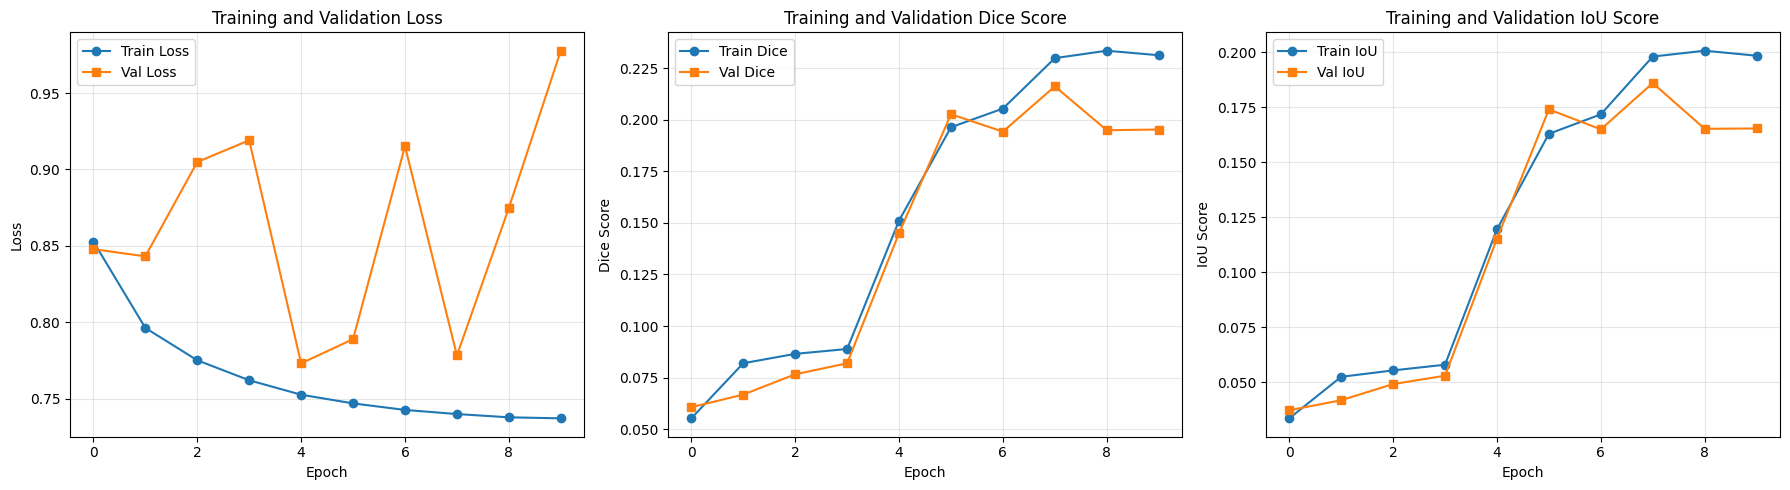

Training history plotted!


In [12]:
# Plot training history
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history['train_dice'], label='Train Dice', marker='o')
axes[1].plot(history['val_dice'], label='Val Dice', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Dice Score')
axes[1].set_title('Training and Validation Dice Score')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].plot(history['train_iou'], label='Train IoU', marker='o')
axes[2].plot(history['val_iou'], label='Val IoU', marker='s')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('IoU Score')
axes[2].set_title('Training and Validation IoU Score')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Training history plotted!")

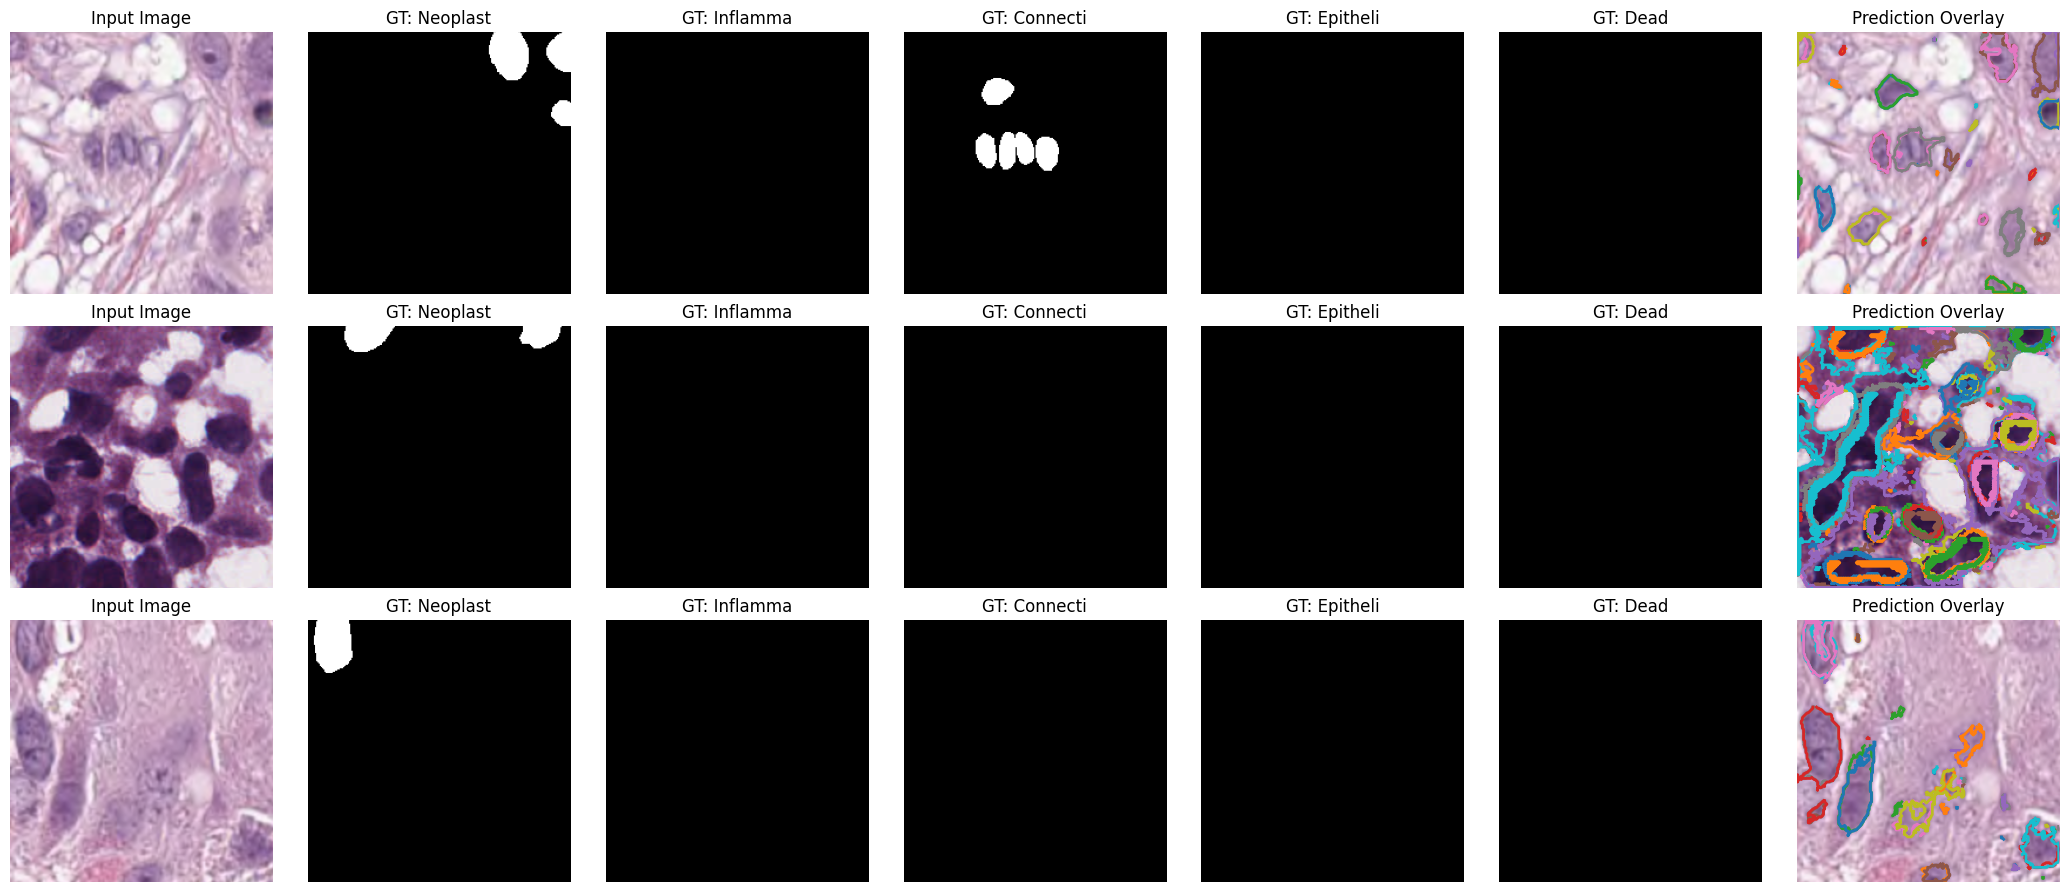

Predictions visualized!


In [13]:
# Visualize sample predictions
def visualize_predictions(model, dataset, device, num_samples=3):
    model.eval()
    
    fig, axes = plt.subplots(num_samples, 7, figsize=(21, 3*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    class_names = ['Neoplastic', 'Inflammatory', 'Connective', 'Epithelial', 'Dead']
    
    with torch.no_grad():
        for i in range(num_samples):
            idx = np.random.randint(0, len(dataset))
            sample = dataset[idx]
            
            image = sample['image'].unsqueeze(0).to(device)
            gt_masks = sample['masks']  # [5, H, W]
            
            # Get prediction (UNet - no text input needed)
            pred_masks = torch.sigmoid(model(image)[0])  # [5, H, W]
            pred_masks = pred_masks.cpu()
            
            # Denormalize image for visualization
            img_display = image[0].cpu().permute(1, 2, 0).numpy()
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img_display = img_display * std + mean
            img_display = np.clip(img_display, 0, 1)
            
            # Plot image
            axes[i, 0].imshow(img_display)
            axes[i, 0].set_title('Input Image')
            axes[i, 0].axis('off')
            
            # Plot GT masks
            for j in range(5):
                axes[i, j+1].imshow(gt_masks[j], cmap='gray', vmin=0, vmax=1)
                axes[i, j+1].set_title(f'GT: {class_names[j][:8]}')
                axes[i, j+1].axis('off')
            
            # Overlay prediction
            axes[i, 6].imshow(img_display)
            for j in range(5):
                mask_pred = (pred_masks[j] > 0.5).numpy()
                if mask_pred.sum() > 0:
                    contours = cv2.findContours((mask_pred*255).astype(np.uint8), 
                                               cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
                    for contour in contours:
                        contour = contour.squeeze()
                        if len(contour) > 2:
                            axes[i, 6].plot(contour[:, 0], contour[:, 1], linewidth=2)
            axes[i, 6].set_title('Prediction Overlay')
            axes[i, 6].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_predictions(model, val_dataset, device, num_samples=3)
print("Predictions visualized!")